# Regrid Fe geothermal vent source from x1 dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from datetime import date, datetime, timezone

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import esmlab
import esmlab_regrid

import pop_tools
import util

id_string = 'Fe_vent_flux_forcing.ipynb from github.com/marbl-ecosys/forcing-Fe-sedflux'

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


## Setup the problem
- specify the input file
- specify the source and destination grids

In [3]:
feventflux_file = f'{util.inputdata}/ocn/pop/gx1v7/forcing/feventflux_gx1v6_5gmol_cesm1_97_2017.nc'
src_grid = 'POP_gx1v7'
dst_grid = 'POP_tx0.1v3'

## Read the input file

Rename the coords/dims to be standard and attach coordinates and grid variables.

In [4]:
ds_src = xr.open_dataset(feventflux_file).rename(
    x='nlon',
    y='nlat',
    z='z_t',
)
ds_src = xr.merge((ds_src, pop_tools.get_grid(src_grid)[['TAREA', 'z_t', 'KMT']]))
ds_src.info()

xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;
	z_t = 60 ;

variables:
	float64 z_t(z_t) ;
	float32 FESEDFLUXIN(z_t, nlat, nlon) ;
	float64 TAREA(nlat, nlon) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
		TAREA:coordinates = TLONG TLAT ;
	int32 KMT(nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
		KMT:coordinates = TLONG TLAT ;

// global attributes:
}

## Setup regridder

In [5]:
method = 'conservative'
weight_file = util.file_name_weight(src_grid, dst_grid, method)
assert os.path.exists(weight_file)
weight_file

'/glade/work/mclong/esmlab-regrid/weights/POP_gx1v7_to_POP_tx0.1v3_conservative.nc'

In [6]:
regrid_operator = esmlab_regrid.regridder(
    name_grid_src=src_grid, 
    name_grid_dst=dst_grid, 
    method=method, 
    overwrite_existing=False
)
regrid_operator

## Perform regridding 

In [7]:
da_dst_lateral = regrid_operator(
        ds_src.FESEDFLUXIN,
        renormalize=True, 
        apply_mask=True
    )

da_dst = util.remap_z_t(da_dst_lateral, src_grid, dst_grid).fillna(0.)
da_dst

<xarray.DataArray 'FESEDFLUXIN' (z_t: 62, nlat: 2400, nlon: 3600)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    regrid_method:  conservative
    history:        \n2020-06-16 09:36:01.459263 esmlab.regrid <regrid>

## Construct output dataset and write to file

In [8]:
ds_dst = pop_tools.get_grid(dst_grid)[['TLONG', 'TLAT', 'TAREA', 'KMT', 'z_t']]
ds_dst['FESEDFLUXIN'] = da_dst #.astype(np.single)
ds_dst.FESEDFLUXIN.encoding = {'_FillValue': None, 'dtype': np.single}
ds_dst.FESEDFLUXIN.attrs['units'] = 'micromol/m^2/d'
ds_dst.FESEDFLUXIN.attrs['long_name'] = 'Fe geothermal vent flux'

for v in ['TAREA', 'TLONG', 'TLAT', 'KMT', 'z_t']:
    ds_dst.encoding['_FillValue'] = None

    
assert ~np.isnan(ds_dst.FESEDFLUXIN.values).any()
    
    
datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
ds_dst.attrs['history'] = f'created by {id_string} on {datestamp}'

datestamp = date.today().strftime("%y%m%d")
file_out = f'{util.dirout}/feventflux_5gmol_{dst_grid}.c{datestamp}.nc'

ds_dst.to_netcdf(file_out)
util.ncks_fl_fmt64bit(file_out)

print(f'wrote: {file_out}')

ds_dst.info()

wrote: /glade/work/mclong/cesm_inputdata/feventflux_5gmol_POP_tx0.1v3.c200616.nc
xarray.Dataset {
dimensions:
	nlat = 2400 ;
	nlon = 3600 ;
	z_t = 62 ;

variables:
	float64 TLONG(nlat, nlon) ;
		TLONG:units = degrees_east ;
		TLONG:long_name = T-grid longitude ;
	float64 TLAT(nlat, nlon) ;
		TLAT:units = degrees_north ;
		TLAT:long_name = T-grid latitude ;
	float64 TAREA(nlat, nlon) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
		TAREA:coordinates = TLONG TLAT ;
	int32 KMT(nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
		KMT:coordinates = TLONG TLAT ;
	float64 z_t(z_t) ;
		z_t:units = cm ;
		z_t:long_name = depth from surface to midpoint of layer ;
		z_t:positive = down ;
	float64 FESEDFLUXIN(z_t, nlat, nlon) ;
		FESEDFLUXIN:regrid_method = conservative ;
		FESEDFLUXIN:history = 
2020-06-16 09:36:01.459263 esmlab.regrid <regrid>  ;
		FESEDFLUXIN:units = micromol/m^2/d ;
		FESEDFLUXIN:long_name = Fe geothermal vent flux ;

// global attributes:

## Compare output with input

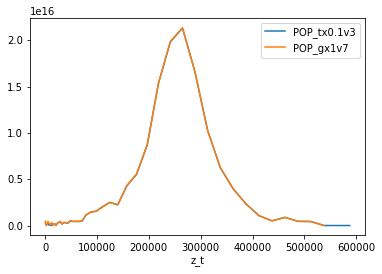

In [9]:
with xr.set_options(keep_attrs=True):
    (ds_dst.FESEDFLUXIN * ds_dst.TAREA).sum(['nlat', 'nlon']).plot(label=dst_grid)
    (ds_src.FESEDFLUXIN * ds_src.TAREA).sum(['nlat', 'nlon']).plot(label=src_grid)
plt.legend();

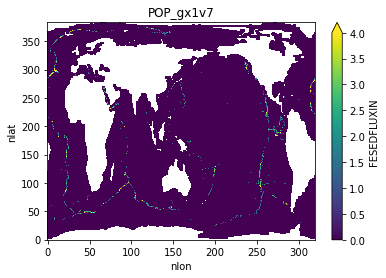

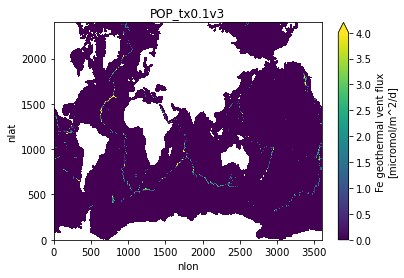

In [10]:
plt.figure()
ds_src.FESEDFLUXIN.sum('z_t').where(ds_src.KMT > 0).plot(vmin=0, vmax=4)
plt.title(src_grid)

plt.figure()
ds_dst.FESEDFLUXIN.sum('z_t').where(ds_dst.KMT > 0).plot(vmin=0, vmax=4)
plt.title(dst_grid);

In [11]:
mol_per_µmol = 1e-6
mol_per_Gmol = 1e9
cm2_per_m2 = 1e4 
d_per_yr = 365.0

def report_global_integral(ds):
    total = esmlab.statistics.weighted_sum(
        ds.FESEDFLUXIN, 
        weights=ds.TAREA/cm2_per_m2, 
        dim=('nlat', 'nlon')).sum('z_t') * mol_per_µmol / mol_per_Gmol * d_per_yr
    print(f'Global integral = {total.values:0.4f} Gmol Fe/yr')

    
print(f'{src_grid}: ', end='')
report_global_integral(ds_src)

print(f'{dst_grid}: ', end='')
report_global_integral(ds_dst)    

POP_gx1v7: Global integral = 5.0480 Gmol Fe/yr
POP_tx0.1v3: Global integral = 4.9662 Gmol Fe/yr
